# Redes Neuronales - Trabajo Práctico N° 2 - Ejercicio 1 - Regresión Logística
# Notebook #2: Implementación de una Regresión Lineal
En esta notebook se busca implementar una regresión logística para poder estimar la condición de diabético de un paciente, perteneciente al Pima Indians Dataset analizado en la notebook anterior.

# TODO List
* Chequear correcto reemplazo de NaN por mean.
* Meter el z-score en scripts comunes a ambos ejercicios. Chequear StandardScaler **correctamente inicializado**. **¿Errores de discretización?**
* ¿Dónde meto el área bajo la curva ROC y el F2? -> Respondido por Luqui y Karina.
* Añadir **tensorboard** para log entre epochs. Migrar **TODOS LOS GRÁFICOS** a TensorBoard.
* Agregar evolución de f2-score sobre train en selección del umbral.

# ¿Qué cosas puedo variar?
* Función de activación:
    * Sigmoid
    * RELU
    * ELU
    * tanh
    * Leaky RELU
    
* Optimizador:
    * SGD
    * Adam
    
* Early Stopping: Para el entrenamiento cuando la **loss** deja de mejorar. Se pasa a través de un **callback**. (https://keras.io/api/callbacks/early_stopping/) (https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)
* Kernel Initializer: Esto es, como son los pesos y bias iniciales. (https://keras.io/api/layers/initializers/)
* Model Checkpoint: Guarda un checkpoint del modelo. Puede configurarse para elegir el mejor. Se pasa por **callback**. (https://keras.io/api/callbacks/model_checkpoint/)
* Scheduling Learning Rate: Se hace variar el **learning rate** con una función. Es un **callback**. (https://keras.io/api/callbacks/learning_rate_scheduler/)
* Reg. dropout: Para evitar overfitting, la capa de dropout "borra" una entrada de forma aleatoria y escala el resto. Es una **capa**. (https://keras.io/api/layers/regularization_layers/dropout/)
* Regularización L1 y L2
* Data Augmentation
* Batch Normalization: Normaliza las entradas (media=0, dev=1). Es una **capa**. (https://keras.io/api/layers/normalization_layers/batch_normalization/)

# Dudas
* Al generar la métrica F2, ¿me devuelve por batch o por epoch? -> Esto finalmente se explica más adelante.
* Al evaluar el predict en threshold selection ¿batch size?

# ¿Cuáles son los requerimientos para el **clasificador**?
* Métrica principal: **Área bajo la curva ROC**
* Buscar el **umbral de decisión** para maximizar el **f2 score** 
* Informar métricas secundarias:
    * Especificidad - Specificity (True Negative rate) measures the proportion of negatives that are correctly identified (i.e. the proportion of those who do not have the condition (unaffected) who are correctly identified as not having the condition).
    * Sensibilidad
    * Valor predictivo positivo
    * Valor predictivo negativo
    
* **Pregunta adicional**:
Dada la situación en la cual cambia la prevalencia de la enfermedad en la población a ser del 20%. Se desea reutilizar el modelo sin volver a entrenar, ¿Cómo lo harían? ¿Qué métricas se mantienen igual y cuáles cambiarian?. **¿clases desbalanceadas -> class weight?**. Las f-score son buenas para casos no balanceados!

# 1. Cargando base de datos

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
# Read database from .csv
df = pd.read_csv('../../databases/diabetes.csv', delimiter=',')

# Show first rows of data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 2. Preprocesamiento de los datos

## 2.1 Filtrado de valores inválidos

In [4]:
# Filtering Glucose values
df['Glucose'].replace(0, np.nan, inplace=True)

# Filtering Blood Pressure values
df['BloodPressure'].replace(0, np.nan, inplace=True)

# Filtering Skin Thickness values
df['SkinThickness'].replace(0, np.nan, inplace=True)

# Filtering Insulin values
df['Insulin'].replace(0, np.nan, inplace=True)

# Filtering Body Mass Index values
df['BMI'].replace(0, np.nan, inplace=True)

# 3. Separación del conjunto de entrenamiento y evaluación

In [5]:
from sklearn import model_selection

In [6]:
from sklearn import preprocessing

In [7]:
# Define input and output variables for the model
x_labels = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction','Age']
y_labels = ['Outcome']

df_x = df[x_labels]
df_y = df[y_labels]

In [8]:
# Split the dataset into train_valid and test
x_train_valid, x_test, y_train_valid, y_test = model_selection.train_test_split(df_x, df_y, test_size=0.2, random_state=15, shuffle=True)

# Split the train_valid sub-dataset into train and valid
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train_valid, y_train_valid, test_size=0.3, random_state=23, shuffle=True)

In [9]:
# Train set before NaN replacement
x_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,429.000000,426.000000,406.000000,287.000000,216.000000,420.000000,429.000000,429.000000
mean,3.906760,120.514085,72.325123,28.930314,152.740741,32.247857,0.469189,33.207459
std,3.350363,29.742282,12.611486,10.041280,107.966521,7.030966,0.330389,11.602100
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000
25%,1.000000,100.000000,64.000000,22.000000,82.000000,27.175000,0.240000,24.000000
50%,3.000000,115.000000,74.000000,29.000000,128.000000,31.750000,0.351000,29.000000
75%,6.000000,138.000000,80.000000,36.000000,185.750000,36.300000,0.646000,41.000000
max,14.000000,198.000000,122.000000,63.000000,680.000000,67.100000,2.420000,72.000000


# 4. Reemplazo de valores inválidos
Como se destacó en el análisis estadístico de datos, el dataset suministrado posee varios valores faltantes en algunos individuos. Se asume que en la etapa de producción el modelo contará con todas las variables correctamente informadas, no admitiendo el faltante de alguna de ellas. Luego, se decide reemplazar aquellos valores inválidos en **train**, **valid** y **test** por la correspondiente media en el dataset de train. En este caso, se considera a la media como un estimador correcto para la ocasión.

In [10]:
# Select columns to perform non-valid values replacement
replace_labels = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Perform NaN replacement
for label in replace_labels:
    # Compute mean for particular column and replace in train, valid and test
    mean = np.nanmean(x_train[label])
    x_train[label].replace(np.nan, mean, inplace=True)
    x_valid[label].replace(np.nan, mean, inplace=True)
    x_test[label].replace(np.nan, mean, inplace=True)

c:\users\joaco\appdata\local\programs\python\python39\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [11]:
# Train set after NaN replacement
x_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,3.906760,120.514085,72.325123,28.930314,152.740741,32.247857,0.469189,33.207459
std,3.350363,29.637862,12.267947,8.208243,76.522025,6.956649,0.330389,11.602100
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000
25%,1.000000,100.000000,64.000000,26.000000,126.000000,27.300000,0.240000,24.000000
50%,3.000000,116.000000,72.325123,28.930314,152.740741,32.000000,0.351000,29.000000
75%,6.000000,138.000000,80.000000,32.000000,152.740741,36.100000,0.646000,41.000000
max,14.000000,198.000000,122.000000,63.000000,680.000000,67.100000,2.420000,72.000000


In [12]:
# Validation set after NaN replacement
x_valid.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,3.908108,124.081233,73.325949,29.225539,156.113313,32.909988,0.471708,33.464865
std,3.474627,30.668200,11.926671,8.568083,87.393680,6.636033,0.325015,11.883040
min,0.000000,44.000000,50.000000,11.000000,15.000000,18.200000,0.084000,21.000000
25%,1.000000,101.000000,65.000000,24.000000,115.000000,28.800000,0.236000,24.000000
50%,3.000000,120.000000,72.000000,28.930314,152.740741,32.500000,0.389000,30.000000
75%,6.000000,145.000000,80.000000,34.000000,152.740741,36.900000,0.600000,40.000000
max,17.000000,199.000000,114.000000,60.000000,545.000000,57.300000,1.893000,81.000000


In [13]:
# Test set after NaN replacement
x_test.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,3.597403,122.038961,71.503903,29.359428,155.872054,32.482778,0.479565,33.064935
std,3.304818,32.320876,11.814455,10.513698,103.288567,6.946169,0.343303,12.118519
min,0.000000,61.000000,30.000000,7.000000,23.000000,18.400000,0.078000,21.000000
25%,1.000000,95.250000,64.000000,23.250000,108.250000,26.925000,0.254000,24.000000
50%,3.000000,117.000000,72.000000,28.930314,152.740741,32.273929,0.376500,28.000000
75%,5.750000,142.750000,80.000000,33.750000,152.740741,36.950000,0.603750,41.000000
max,13.000000,197.000000,106.000000,99.000000,846.000000,55.000000,2.329000,69.000000


# 5. Normalización de datos de entrada. Z Score. 
Dado que todas las variables en juego son numéricas, se puede aplicar z-score a todo el dataset. Esta operación se hace con el objetivo de poder obtener mayor información de los pesos calculados por el modelo.

In [14]:
# Apply z-score to all sub-datasets
scalable_variables = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction','Age']

if scalable_variables:
    # Create an instance of the StandardScaler for each variable
    scaler = preprocessing.StandardScaler()

    # Fit the distribution
    scaler.fit(x_train.loc[:, scalable_variables])

    # Transform and normalize all variables
    x_train.loc[:, scalable_variables] = scaler.transform(x_train.loc[:, scalable_variables])
    x_test.loc[:, scalable_variables] = scaler.transform(x_test.loc[:, scalable_variables])
    x_valid.loc[:, scalable_variables] = scaler.transform(x_valid.loc[:, scalable_variables])

c:\users\joaco\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\users\joaco\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\users\joaco\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:17

In [15]:
x_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,4.290000e+02,4.290000e+02,4.290000e+02,4.290000e+02,4.290000e+02,4.290000e+02,4.290000e+02,4.290000e+02
mean,-4.140692e-17,-7.349728e-17,-5.341493e-16,-5.300086e-16,4.140692e-17,-6.211038e-18,5.175865e-17,-1.407835e-16
std,1.001168e+00,1.001168e+00,1.001168e+00,1.001168e+00,1.001168e+00,1.001168e+00,1.001168e+00,1.001168e+00
min,-1.167432e+00,-2.179287e+00,-3.943736e+00,-2.674862e+00,-1.815199e+00,-2.021700e+00,-1.164196e+00,-1.053405e+00
25%,-8.686085e-01,-6.929662e-01,-6.794000e-01,-3.574133e-01,-3.498596e-01,-7.120718e-01,-6.945041e-01,-7.945294e-01
50%,-2.709613e-01,-1.524859e-01,0.000000e+00,-4.333280e-16,0.000000e+00,-3.567041e-02,-3.581441e-01,-3.630697e-01
75%,6.255096e-01,5.906746e-01,6.263344e-01,3.744127e-01,0.000000e+00,5.543819e-01,5.357857e-01,6.724333e-01
max,3.016099e+00,2.617476e+00,4.053887e+00,4.155514e+00,6.898339e+00,5.015753e+00,5.911486e+00,3.347483e+00


# 6. Regresión Logística - Test #1
Primera prueba de regresión logística. Se usa SGD y AUC como métrica principal. Se emplea la Binary Cross-Entropy como loss subrogada, dado que **la AUC no es diferenciable**.

In [16]:
# Loading TensorBoard for learning logging
%load_ext tensorboard

In [17]:
import tensorflow as tf
import datetime

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [18]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.metrics import SensitivityAtSpecificity
from keras.callbacks import TensorBoard

In [19]:
# Sequential model
model = Sequential()
model.add(Dense(1, input_shape=(8,), activation='sigmoid', use_bias=True))

# Get model brief
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Metrics definition
metrics = ['AUC', 'accuracy']

In [21]:
# Compiling model
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=metrics)
# Configuring TensorBoard to log learning process
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# Training model
model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=200, batch_size=32, verbose='auto', callbacks=[tensorboard_callback])

Epoch 1/200
14/14 [==============================] - 14s 134ms/step - loss: 0.7046 - auc: 0.5996 - accuracy: 0.5726 - val_loss: 0.7292 - val_auc: 0.5447 - val_accuracy: 0.5351
Epoch 2/200
14/14 [==============================] - 0s 7ms/step - loss: 0.6753 - auc: 0.6418 - accuracy: 0.6085 - val_loss: 0.7131 - val_auc: 0.5654 - val_accuracy: 0.5405
Epoch 3/200
14/14 [==============================] - 0s 7ms/step - loss: 0.6735 - auc: 0.6387 - accuracy: 0.6056 - val_loss: 0.6984 - val_auc: 0.5866 - val_accuracy: 0.5514
Epoch 4/200
14/14 [==============================] - 0s 7ms/step - loss: 0.6639 - auc: 0.6434 - accuracy: 0.6421 - val_loss: 0.6846 - val_auc: 0.6056 - val_accuracy: 0.5676
Epoch 5/200
14/14 [==============================] - 0s 7ms/step - loss: 0.6383 - auc: 0.6935 - accuracy: 0.6453 - val_loss: 0.6725 - val_auc: 0.6255 - val_accuracy: 0.5892
Epoch 6/200
14/14 [==============================] - 0s 8ms/step - loss: 0.6459 - auc: 0.6814 - accuracy: 0.6430 - val_loss: 0.6612 

In [22]:
# TensorBoard launch
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 20012), started 1:39:25 ago. (Use '!kill 20012' to kill it.)

In [23]:
eval = model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.5278 - auc: 0.7985 - accuracy: 0.7468


# 7. Elección del umbral usando f2 score

A la prueba anterior, se suma la selección del umbral (o **threshiold**) con el cual el clasificador discrimina entre clases. El mejor umbral de clasificación se calcula para todos los modelos, después del correspondiente entrenamiento. Para esta elección se elije el mejor valor del f2-score sobre el subset de **valid**. También se muestra la evolución de esta métrica respecto al umbral en el subset de **train**. En teoría, este umbral **no modifica la mérica principal del modelo, que es el área bajo la curva ROC**.

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score

def round_threshold(vector, threshold=0.5):
    rounded_vector = []
    for element in vector:
        if element >= threshold:
            rounded_vector.append(1)
        else:
            rounded_vector.append(0)
            
    return np.array(rounded_vector)
        
def f2_threshold_selection(y_probs_valid, y_true_valid, y_probs_train, y_true_train, steps=100, plot=True):
    # Thresholds and f2-score vectors
    thresholds = np.linspace(0, 1, steps)
    f2_score_valid = []
    f2_score_train = []
    
    for thld in thresholds:
        # Generate predictions with current threshold
        y_pred_valid = round_threshold(vector=y_probs_valid, threshold=thld)
        y_pred_train = round_threshold(vector=y_probs_train, threshold=thld)
        # Compute f2 score for that threshold and append
        score_valid = fbeta_score(y_true=y_true_valid, y_pred=y_pred_valid, beta=2)
        score_train = fbeta_score(y_true=y_true_train, y_pred=y_pred_train, beta=2)
        f2_score_valid.append(score_valid)
        f2_score_train.append(score_train)
    
    idx = np.argmax(f2_score_valid)
    if plot == True:
        plt.plot(thresholds, f2_score_valid, label='valid')
        plt.plot(thresholds, f2_score_train, label='train')
        plt.xlabel('Threshold')
        plt.ylabel('F2 score')
        plt.axvline(thresholds[idx], color='black', linestyle='--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.grid(b=True)
        plt.legend()
        plt.show()
        
    return thresholds, f2_score_valid, idx
    
    

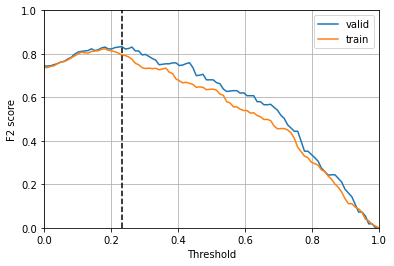

0.23232323232323235

In [25]:
# Get binary-class probability from model
y_probs_valid = model.predict(x_valid)
y_probs_train = model.predict(x_train)
thresholds, f2_score, idx = f2_threshold_selection(y_probs_valid, y_valid, y_probs_train, y_train, steps=100)
thresholds[idx]

# 8. Early Stopping
Habiendo concluido el test #1, se cree necesario agregar un callback de early stopping al modelo. Este callback deberá detener el proceso de aprendizaje en el momento en el que la **métrica principal** del modelo **deje de aumentar**. Posteriormente, se recupera el modelo con mejor performance en cuanto a esta métrica (AUC). Cabe aclarar que esta técnica es especialmente útil cuando la métrica principal no es diferenciable, y por ende se debe emplear una **loss subrogada** (en este caso, la binary cross entropy). De esta forma, el número de epochs que recorra el proceso de entrenamiento se verá limitada.

In [26]:
# Import Early Stopping callback from keras.
from keras.callbacks import EarlyStopping

In [27]:
# Confugure Early Stopping callback
es = EarlyStopping(monitor='val_auc', mode='max', min_delta=0.001, patience=10, restore_best_weights=True)

In [28]:
# Compiling model
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=metrics)
# Configuring TensorBoard to log learning process
log_dir = "logs/fit/ES/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# Training model
model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=1000, batch_size=32, verbose=1, callbacks=[tensorboard_callback, es])

Epoch 1/1000
14/14 [==============================] - 3s 169ms/step - loss: 0.4656 - auc: 0.8431 - accuracy: 0.7847 - val_loss: 0.4459 - val_auc: 0.8631 - val_accuracy: 0.7730
Epoch 2/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.4537 - auc: 0.8586 - accuracy: 0.7905 - val_loss: 0.4458 - val_auc: 0.8633 - val_accuracy: 0.7730
Epoch 3/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.4729 - auc: 0.8326 - accuracy: 0.7869 - val_loss: 0.4458 - val_auc: 0.8634 - val_accuracy: 0.7730
Epoch 4/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.4297 - auc: 0.8693 - accuracy: 0.8160 - val_loss: 0.4458 - val_auc: 0.8638 - val_accuracy: 0.7730
Epoch 5/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.4435 - auc: 0.8583 - accuracy: 0.7980 - val_loss: 0.4457 - val_auc: 0.8639 - val_accuracy: 0.7730
Epoch 6/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.4654 - auc: 0.8501 - accuracy: 0.7854 - val_loss: 0.

In [29]:
# Evaluate test subset and predict.
eval = model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.5279 - auc: 0.7979 - accuracy: 0.7403


# 9. Learning Rate Scheduling
En este apartado se prueba la opción de Learning Rate Scheduling. Esta se encarga de aplicarle una función al Learning Rate entre epochs, de forma tal de encontrar el mínimo de la loss de forma más rápida, y apuntando a evitar mínimos locales y, por ende, overfitting. Se sigue aplicando el concepto de **early stopping** para la AUC. 

In [30]:
from keras.optimizers import SGD
from keras.optimizers.schedules import ExponentialDecay, PolynomialDecay # API in https://keras.io/api/optimizers/learning_rate_schedules/

In [31]:
# Creating new model
lrs_model = Sequential()
lrs_model.add(Dense(1, input_shape=(8,), activation='sigmoid', use_bias=True))

In [32]:
# Define learning rate at start
ilr = 0.1
lr_schedule = ExponentialDecay(ilr, decay_steps=100000, decay_rate=0.96, staircase=False) # Decay every (decay_steps) steps with a base of (decay_rate).
# Compiling model
lrs_model.compile(optimizer=SGD(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=metrics)
# Training model
lrs_model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=200, batch_size=32, verbose='auto', callbacks=[tensorboard_callback, es])

Epoch 1/200
14/14 [==============================] - 2s 111ms/step - loss: 0.7484 - auc: 0.5901 - accuracy: 0.5526 - val_loss: 0.6434 - val_auc: 0.7046 - val_accuracy: 0.6703
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6114 - auc: 0.7051 - accuracy: 0.6736 - val_loss: 0.5606 - val_auc: 0.7923 - val_accuracy: 0.7405
Epoch 3/200
14/14 [==============================] - 0s 5ms/step - loss: 0.5332 - auc: 0.8013 - accuracy: 0.7274 - val_loss: 0.5187 - val_auc: 0.8298 - val_accuracy: 0.7405
Epoch 4/200
14/14 [==============================] - 0s 4ms/step - loss: 0.5053 - auc: 0.8196 - accuracy: 0.7578 - val_loss: 0.4946 - val_auc: 0.8438 - val_accuracy: 0.7784
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4731 - auc: 0.8471 - accuracy: 0.7730 - val_loss: 0.4790 - val_auc: 0.8531 - val_accuracy: 0.7784
Epoch 6/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4934 - auc: 0.8306 - accuracy: 0.7809 - val_loss: 0.4691 -

In [33]:
# Evaluate model with test subset.
eval = lrs_model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 0s 1ms/step - loss: 0.5262 - auc: 0.8023 - accuracy: 0.7532


**PREGUNTA**: ¿Exponential Decay se lleva bien con Early Stopping?, ya que si reduzco el learning rate "me muevo menos", con lo cual el callback de Early Stopping cortaría prematuramente. Ahora probamos sin Early Stopping.

In [34]:
# Training model
lrs_model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=200, batch_size=32, verbose='auto', callbacks=[tensorboard_callback])

Epoch 1/200
14/14 [==============================] - 1s 45ms/step - loss: 0.4656 - auc: 0.8458 - accuracy: 0.7855 - val_loss: 0.4495 - val_auc: 0.8658 - val_accuracy: 0.7676
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4643 - auc: 0.8463 - accuracy: 0.7832 - val_loss: 0.4478 - val_auc: 0.8651 - val_accuracy: 0.7676
Epoch 3/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4635 - auc: 0.8462 - accuracy: 0.7809 - val_loss: 0.4468 - val_auc: 0.8656 - val_accuracy: 0.7676
Epoch 4/200
14/14 [==============================] - 0s 4ms/step - loss: 0.4622 - auc: 0.8466 - accuracy: 0.7902 - val_loss: 0.4456 - val_auc: 0.8653 - val_accuracy: 0.7622
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4616 - auc: 0.8483 - accuracy: 0.7832 - val_loss: 0.4450 - val_auc: 0.8646 - val_accuracy: 0.7622
Epoch 6/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4610 - auc: 0.8478 - accuracy: 0.7925 - val_loss: 0.4446 - 

In [35]:
# Evaluate model with test subset.
eval = lrs_model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 0s 1ms/step - loss: 0.5353 - auc: 0.7981 - accuracy: 0.7403
